In [1]:
!pip install -e .

Defaulting to user installation because normal site-packages is not writeable
Obtaining file:///hpc/group/ultrasound/wew12/modules/pyus
  Preparing metadata (setup.py) ... done
  Attempting uninstall: pyus
    Found existing installation: pyus 0.0.2
    Uninstalling pyus-0.0.2:
      Successfully uninstalled pyus-0.0.2
  Running setup.py develop for pyus


In [2]:
import pyus.data.io as dio
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig

In [3]:
import h5py
with h5py.File("sampledata.hdf5", mode='r') as f:

    params = {}
    L74 = {}

    for (k, v) in f['params']['L74'].items():
        L74[k] = np.array(v)
    
    for (k, v) in f['params'].items():
        if k == 'L74':
            continue
        params[k] = np.array(v)

    DSF = 1

    traces = [np.array(f['data_neg']['traces'])[::DSF,:], np.array(f['data_0']['traces'])[::DSF,:], np.array(f['data_pos']['traces'])[::DSF,:]]
    tau_ts = [np.array(f['data_neg']['tau_t']), np.array(f['data_0']['tau_t']), np.array(f['data_pos']['tau_t'])]
    tau_r0s = [np.array(f['data_neg']['tau_r0']), np.array(f['data_0']['tau_r0']), np.array(f['data_pos']['tau_r0'])]
    tstarts = [np.array(f['data_neg']['tstart']), np.array(f['data_0']['tstart']), np.array(f['data_pos']['tstart'])]
    tau_ts = [tau_t - np.min(tau_t) for tau_t in tau_ts]
    tau_r0s = [tau_t - np.min(tau_t) for tau_t in tau_r0s]

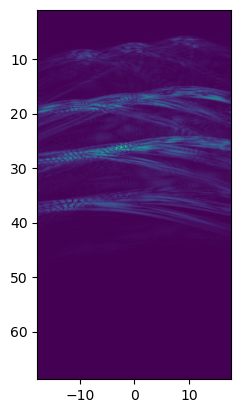

In [4]:
tracenum = 1
extent = np.array([-1E3*L74['nele']*L74['width']/2,
        1E3*L74['nele']*L74['width']/2,
        DSF*1E3*(traces[tracenum].shape[0]/params['fs']+tstarts[tracenum])*params['c']/2, 
        1E3*tstarts[tracenum]*params['c']/2])
plt.figure()
plt.imshow(np.abs(sig.hilbert(traces[0])), extent=extent, aspect=1)
plt.show()

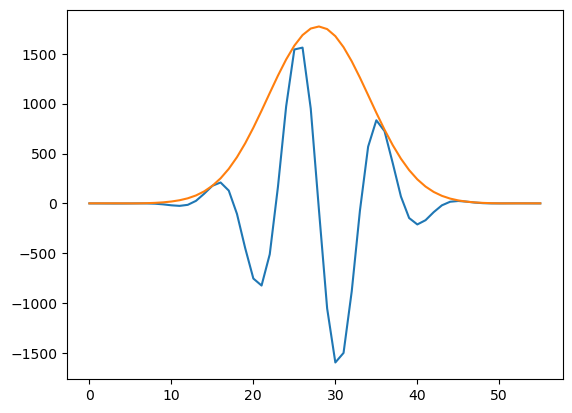

28.0 5.6e-07 0.8624


In [5]:
# find delay from t=0 to peak of pulse
import scipy.signal as sig
trans = np.convolve(params['imp'].flatten(), params['ex'].flatten())
trans_env = np.abs(sig.hilbert(trans))
plt.figure()
plt.plot(trans)
plt.plot(trans_env)
plt.show()
max_ind = np.mean(trans_env.argmax())
dt_peak = max_ind/params['fs']
print(max_ind, dt_peak, 1E3*1540 * dt_peak)

## Test demodulation function

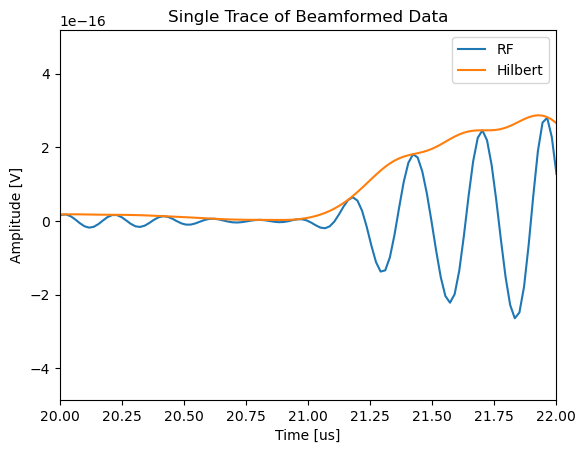

In [6]:
import pyus.ustools.bmfrm as bmfrm
# plot a signal from data
trace = traces[0][:, 64]
t = 2*np.linspace(extent[3], extent[2], num=len(trace))/params['c']
plt.figure()
plt.plot(1E3*t, trace, label='RF')
plt.plot(1E3*t, np.abs(sig.hilbert(trace)), label='Hilbert')
plt.xlabel('Time [us]')
plt.ylabel('Amplitude [V]')
plt.title("Single Trace of Beamformed Data")
plt.xlim([20, 22])
plt.legend()
plt.show()

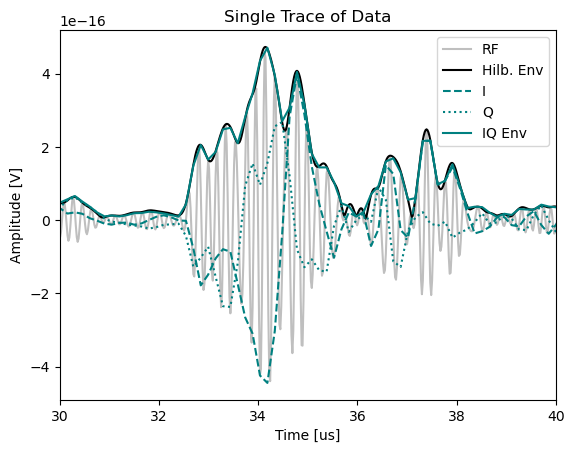

In [7]:
usf=4
dsf=8
I, Q = bmfrm.demodulate(trace, axis=0, usf=usf, dsf=usf*dsf, fd=1*L74['fc'], fs=params['fs'], fc=L74['fc'], tstart=t[0])

t_iq = t[::dsf]

# plt.figure()
# plt.plot(I, label='I', c=[0,0.5,0.5], linestyle='--')
# plt.plot(Q, label='Q', c=[0,0.5,0.5], linestyle=':')
# plt.plot(np.sqrt(I**2 + Q**2), linestyle='-', label="IQ Env", c=[0,0.5,0.5])
# plt.xlabel('Time [us]')
# plt.ylabel('Amplitude [V]')
# plt.title("Single Trace of Data")
# plt.xlim([1500, 1600])
# plt.legend()
# plt.show()

plt.figure()
plt.plot(1E3*t, trace, label='RF', alpha=0.25, c=[0,0,0], linestyle='-')
plt.plot(1E3*t, np.abs(sig.hilbert(trace)), label='Hilb. Env', c=[0,0,0])
plt.plot(1E3*t_iq, I, label='I', c=[0,0.5,0.5], linestyle='--')
plt.plot(1E3*t_iq, Q, label='Q', c=[0,0.5,0.5], linestyle=':')
plt.plot(1E3*t_iq, np.sqrt(I**2 + Q**2), linestyle='-', label="IQ Env", c=[0,0.5,0.5])
plt.xlabel('Time [us]')
plt.ylabel('Amplitude [V]')
plt.title("Single Trace of Data")
plt.xlim(30,40)
plt.legend()
plt.show()

rf = bmfrm.remodulate(I, Q, axis=0, fd=L74['fc'], fs=params['fs'], fc=L74['fc'], tstart=t[0])

# plt.figure()
# plt.plot(1E3*t, trace, label='RF', alpha=0.25, c=[0,0,0], linestyle='-')
# plt.plot(1E3*t, rf, label='Remodulated', c=[0,0.5,0.5], linestyle='--')
# plt.xlabel('Time [us]')
# plt.ylabel('Amplitude [V]')
# plt.title("Single Trace of Data")
# plt.xlim([22.5, 27.5])
# plt.legend()
# plt.show()

In [8]:
import pyus.ustools.bmfrm as bmfrm
step = L74['width'] + L74['kerf']
lat_in = np.linspace(-(L74['nele']-1)*step/2, (L74['nele']-1)*step/2, num=L74['nele'])
lat_out = np.linspace(-(L74['nele']-1)*step/2, (L74['nele']-1)*step/2, num=2*L74['nele'])
ax_out = np.linspace(1e-3, 40e-3, num=1024)

ax_in = np.linspace((tstarts[0])*params['c']/2, 
    (traces[0].shape[0]/params['fs']+tstarts[0])*params['c']/2, 
    num=traces[0].shape[0])

print(lat_in[0], lat_in[-1])
print(lat_out[0], lat_out[-1])

fnum=1

BFneg = bmfrm.PWBeamformer(
    axial_in=ax_in, 
    lateral_in=lat_in,
    axial_out=ax_out, 
    lateral_out=lat_out, 
    axial_mode='spacespace',
    alpha=-15*np.pi/180,
    fnum=fnum,
    dt_peak=dt_peak)

ax_in = np.linspace(tstarts[1]*params['c']/2, 
    (traces[1].shape[0]/params['fs']+tstarts[1])*params['c']/2, 
    num=traces[1].shape[0])

BF0 = bmfrm.PWBeamformer(
    axial_in=ax_in, 
    lateral_in=lat_in,
    axial_out=ax_out, 
    lateral_out=lat_out, 
    axial_mode='spacespace',
    alpha=0*np.pi/180,
    fnum=fnum,
    dt_peak=dt_peak)

ax_in = np.linspace(tstarts[2]*params['c']/2, 
    (traces[2].shape[0]/params['fs']+tstarts[2])*params['c']/2, 
    num=traces[2].shape[0])

BFpos = bmfrm.PWBeamformer(
    axial_in=ax_in, 
    lateral_in=lat_in,
    axial_out=ax_out, 
    lateral_out=lat_out, 
    axial_mode='spacespace',
    alpha=15*np.pi/180,
    fnum=fnum,
    dt_peak=dt_peak)

-0.018923 0.018923
-0.018923 0.018923


In [9]:
formed_neg = BFneg.form(traces[0])
formed_0 = BF0.form(traces[1])
formed_pos = BFpos.form(traces[2])

In [10]:
summed = np.nanmean(np.array([formed_neg, formed_0, formed_pos]), axis=0)
max_summed = np.max(summed)

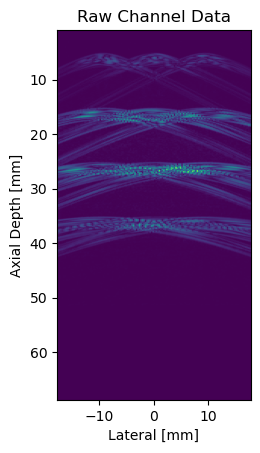

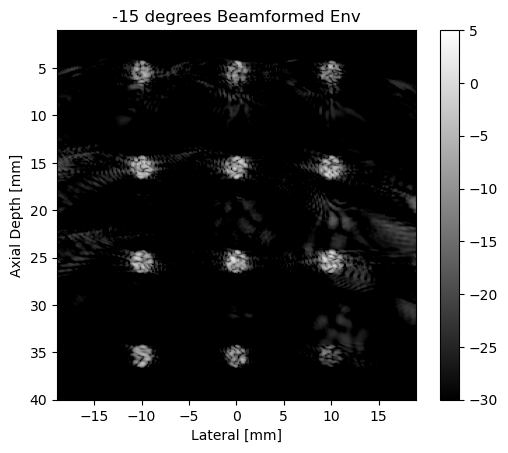

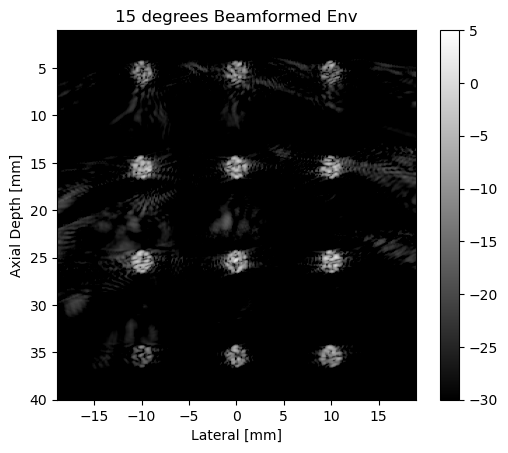

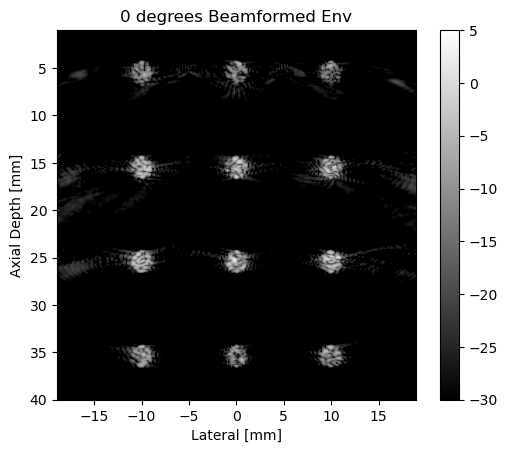

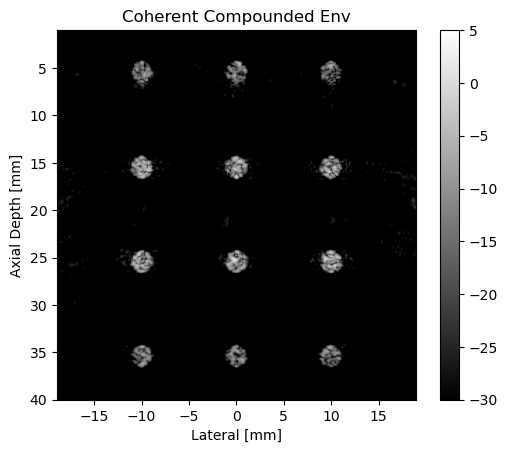

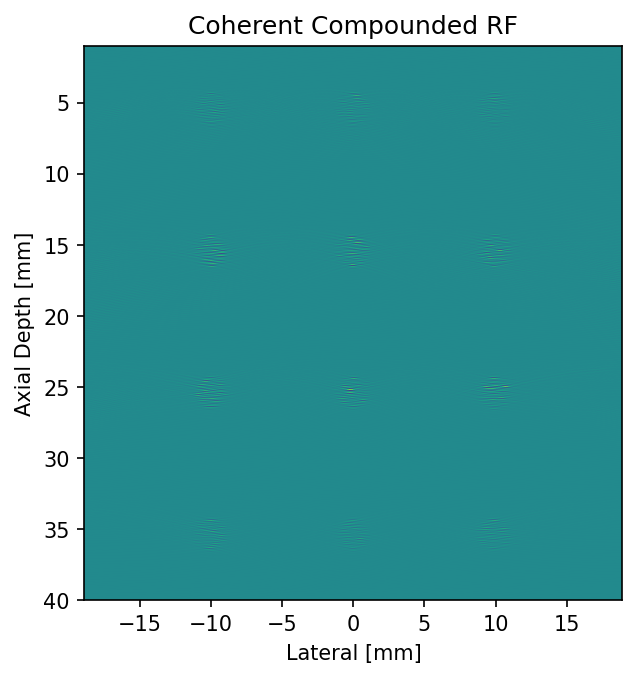

In [11]:
vmin = -30
vmax = 5
cmap = 'gray'
plt.figure()
plt.imshow(np.abs(sig.hilbert(traces[1], axis=0)), extent=extent)
plt.title("Raw Channel Data")
plt.ylabel('Axial Depth [mm]')
plt.xlabel('Lateral [mm]')
plt.show()

extent_formed = 1E3*np.array([np.min(lat_out), np.max(lat_out), np.max(ax_out), np.min(ax_out)])
plt.figure()
plt.imshow(20*np.log10(np.abs(sig.hilbert(formed_neg/max_summed, axis=0))), extent=extent_formed, vmin=vmin, vmax=vmax, cmap=cmap)
plt.colorbar()
plt.ylim([40, 1])
plt.title("-15 degrees Beamformed Env")
plt.ylabel('Axial Depth [mm]')
plt.xlabel('Lateral [mm]')
plt.show()

plt.figure()
plt.imshow(20*np.log10(np.abs(sig.hilbert(formed_pos/max_summed, axis=0))), extent=extent_formed, vmin=vmin, vmax=vmax, cmap=cmap)
plt.colorbar()
plt.ylim([40, 1])
plt.title("15 degrees Beamformed Env")
plt.ylabel('Axial Depth [mm]')
plt.xlabel('Lateral [mm]')
plt.show()

plt.figure()
plt.imshow(20*np.log10(np.abs(sig.hilbert(formed_0/max_summed, axis=0))), extent=extent_formed, vmin=vmin, vmax=vmax, cmap=cmap)
plt.colorbar()
plt.ylim([40, 1])
plt.title("0 degrees Beamformed Env")
plt.ylabel('Axial Depth [mm]')
plt.xlabel('Lateral [mm]')
plt.show()

plt.figure()
plt.imshow(20*np.log10(np.abs(sig.hilbert(summed/max_summed, axis=0))), extent=extent_formed, vmin=vmin, vmax=vmax, cmap=cmap)
plt.colorbar()
plt.ylim([40, 1])
plt.title("Coherent Compounded Env")
plt.ylabel('Axial Depth [mm]')
plt.xlabel('Lateral [mm]')
plt.show()

plt.figure(dpi=150)
plt.imshow(formed_0,extent=extent_formed)
plt.ylim([40, 1])
plt.title("Coherent Compounded RF")
plt.ylabel('Axial Depth [mm]')
plt.xlabel('Lateral [mm]')
plt.show()

In [12]:
newrf = {}
with h5py.File('testnewrf.h5', 'r') as f:
    for (k,v) in f.items():
        newrf[k] = np.array(v)

In [13]:
BF = bmfrm.PWBeamformer(
    axial_in=newrf['axrf'], 
    lateral_in=newrf['lat']-(newrf['lat'][-2]-newrf['lat'][-1])/2,
    axial_out=newrf['axbf'], 
    lateral_out=newrf['lat']-(newrf['lat'][-2]-newrf['lat'][-1])/2, 
    axial_mode='timespace',
    alpha=newrf['angle'],
    fnum=fnum,
    dt_peak=dt_peak)
beamformed = BF(data=newrf['rf'], fill_val = 1E-100)
beamformed = beamformed/np.max(np.abs(beamformed))

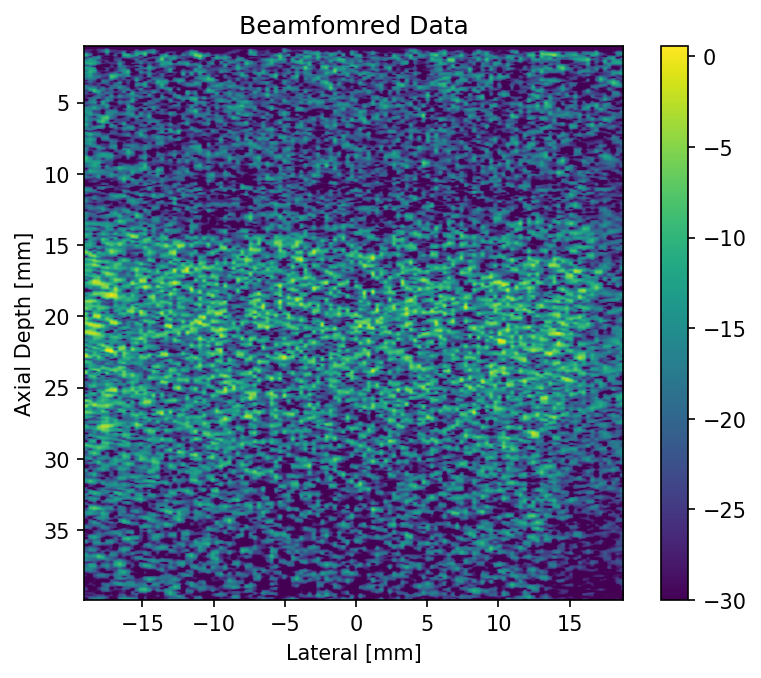

In [14]:
plt.figure(dpi=150)
extent = [1E3*np.min(newrf['lat']), 1E3*np.max(newrf['lat']), 1E3*np.max(newrf['axbf']), 1E3*np.min(newrf['axbf'])]
plt.imshow(20*np.log10(np.abs(sig.hilbert(beamformed, axis=0))),extent=extent, vmin=-30)
plt.title("Beamfomred Data")
plt.ylabel('Axial Depth [mm]')
plt.xlabel('Lateral [mm]')
plt.colorbar()
plt.show()

In [15]:
print("Axrf sampling period [m]:", 1540*(newrf['axrf'][-1] - newrf['axrf'][-2])/2)
print("Axbf sampling period [m]:", newrf['axbf'][-1] - newrf['axbf'][-2])

Axrf sampling period [m]: 3.84999999999905e-05
Axbf sampling period [m]: 3.849999999999687e-05


In [16]:
from pyus.ustools import dispest as de

In [17]:
data = dio.loadHDF5("disptest_totalsummed.h5")
data.keys()
data['axaxis']

array(1)

In [23]:
import logging
logging.basicConfig()
logging.getLogger().setLevel(logging.INFO)

In [24]:
disp = de.calc_kasai(data['I'], data['Q'], taxis = data['taxis'], ksize = 3, kaxis=int(data['axaxis']), fd=5E6)
print(disp.shape)

INFO:pyus.ustools.dispest:Using progressive referencing
INFO:pyus.ustools.dispest:Scaling returned displacements to microns.


(200, 127, 128)


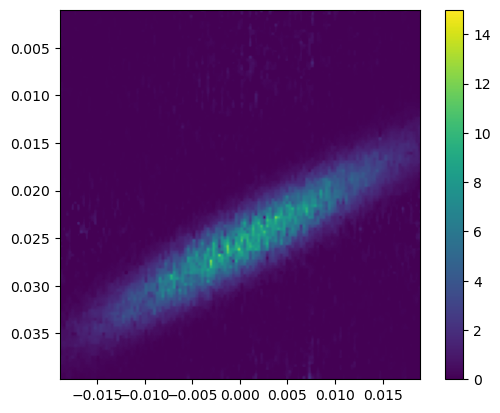

In [25]:
extent = [np.min(data['lat']), np.max(data['lat']), np.max(data['ax']), np.min(data['ax'])]
plt.figure()
plt.imshow(disp[0,:,:], vmin=0, vmax=15, extent=extent)
plt.colorbar()
plt.show()

INFO:pyus.ustools.dispest:Using fixed referencing
INFO:pyus.ustools.dispest:Scaling returned displacements to microns.


(200, 127, 128)


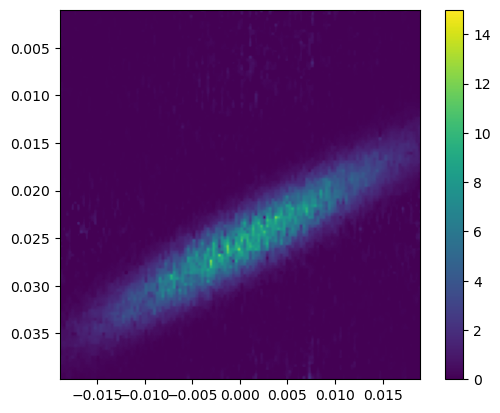

In [26]:
disp = de.calc_kasai(data['I'], data['Q'], taxis = data['taxis'], ksize = 3, kaxis=int(data['axaxis']), fd=5E6, progressive=False)
print(disp.shape)
extent = [np.min(data['lat']), np.max(data['lat']), np.max(data['ax']), np.min(data['ax'])]
plt.figure()
plt.imshow(disp[0,:,:], vmin=0, vmax=15, extent=extent)
plt.colorbar()
plt.show()